In [3]:
%matplotlib inline


# Independent and identically distributed returns

A very common assumption in modelling of financial returns is independence in time.
In other words, there is no use in considering today (or any other past day) returns to predict
tomorrow returns. Another very popular assumption is that returns have the same distribution.
Combining both of these assumptions we basically claim that there is some underlying multivariate
distribution and the actual returns we observe are just independent samples from it.

:code:`deepdow` can be applied in a market with the above described IID dynamics. This example will
analyze how good :code:`deepdow` is at learning optimal portfolios given these dynamics.


<div class="alert alert-info"><h4>Note</h4><p>:code:`deepdow` contains many tools that help extract hidden features from the original ones. However,
    under the IID setup we are in a position where the lagged returns have no predictive value. We
    have zero features which is very unusual from the point of view of standard machine learning
    applications. However, nothing prevents us from learning a set of constants that uniquely determine
    the final allocation. As in the more standard case with features, these parameters
    can be learned via minimization of an empirical loss like mean returns, sharpe ratio, etc.</p></div>

This example is divided into the following sections

1. Creation of synthetic return series
2. Convex optimization given the ground truth
3. Sample estimators of covmat and mean
4. Implementation and setup of a :code:`deepdow` network
5. Training and evaluation


## Preliminaries
Let us start with importing all important dependencies.



In [1]:
import cvxpy as cp
from deepdow.benchmarks import Benchmark
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader
from deepdow.layers import NumericalMarkowitz
from deepdow.losses import MeanReturns, StandardDeviation
from deepdow.experiments import Run
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

Let us also set seeds for both :code:`numpy` and :code:`torch`.



In [2]:
torch.manual_seed(4)
np.random.seed(21)

## Creation of synthetic return series
To ensure that we generate realistic samples we are going to use S&P500 stocks. Namely, we precomputed
daily mean returns and covariance matrix for a subset of all the stocks and one can just simply
load them.



In [4]:
mean_all = pd.read_csv('sp500_mean.csv', index_col=0, header=None).iloc[:, 0]
covmat_all = pd.read_csv('sp500_covmat.csv', index_col=0)

Let us now randomly select some assets



In [5]:
n_assets = 15

asset_ixs = np.random.choice(len(mean_all), replace=False, size=n_assets)
mean = mean_all.iloc[asset_ixs]
covmat = covmat_all.iloc[asset_ixs, asset_ixs]

These are the expected returns



<Axes: ylabel='0'>

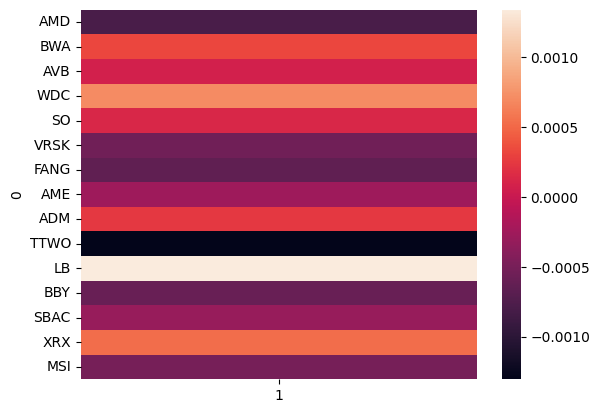

In [6]:
sns.heatmap(mean.to_frame())

And this is the covariance matrix



<Axes: >

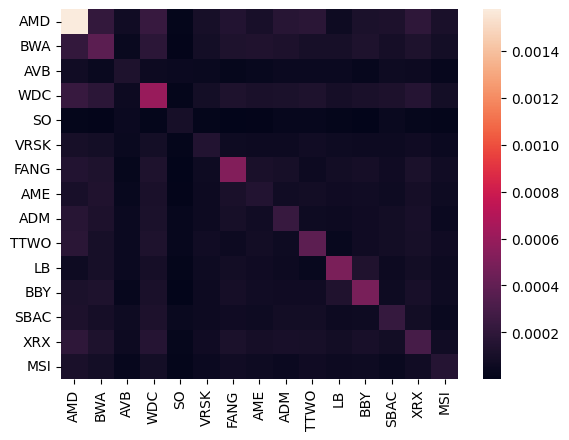

In [7]:
sns.heatmap(covmat)

Additionally let us inspect them in the risk and return plane



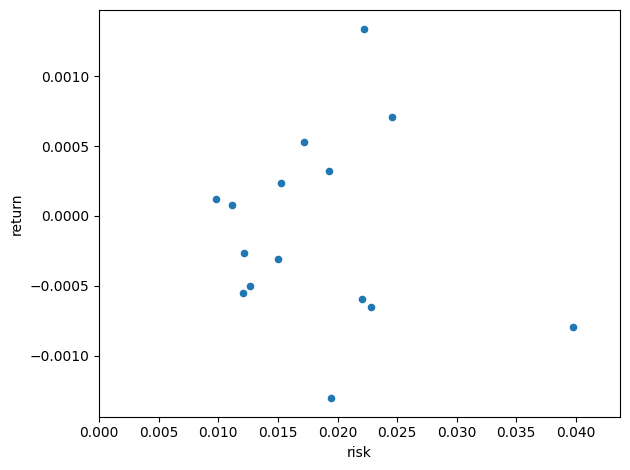

In [8]:
df_risk_ret = pd.DataFrame({'risk': np.diag(covmat) ** (1 / 2),
                            'return': mean.values})

x_lim = (0, df_risk_ret['risk'].max() * 1.1)
y_lim = (df_risk_ret['return'].min() * 1.1, df_risk_ret['return'].max() * 1.1)
ax = df_risk_ret.plot.scatter(x='risk', y='return')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.tight_layout()

From now on we see the mean and covmat as the ground truth parameters that fully determine the
market dynamics. We now generate some samples from a multivariate normal distribution with
mean and covmat as the defining parameters.



<Axes: xlabel='0'>

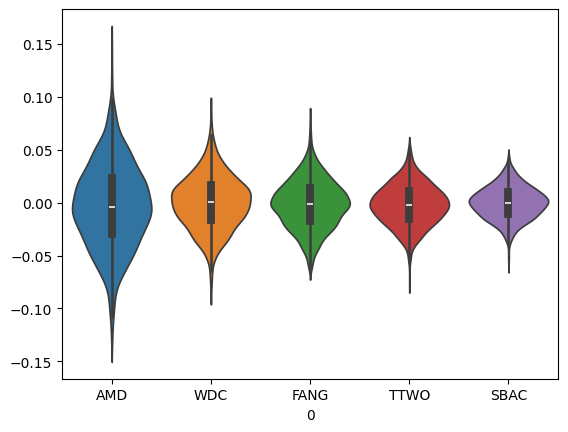

In [9]:
n_timesteps = 1500
returns = pd.DataFrame(np.random.multivariate_normal(mean.values,
                                                     covmat.values,
                                                     size=n_timesteps,
                                                     check_valid='raise'), columns=mean.index)

sns.violinplot(data=returns.iloc[:, ::3])

## Convex optimization given the ground truth
Since we posses the ground truth mean and covmat we can find optimal weight allocation given
some **objective** and **constraints**. We are going to consider the following objectives

- Minimum variance
- Maximum return
- Maximum utility

Since the combination of our objective and constraints will result in a convex optimization problem
we can be sure that the optimal solution exists and is unique. Additionally, we will use
:code:`cvxpy` to find the solution numerically. For simplicity, we will refer to all of these
optimization problems as *Markowitz optimization problems*. See below the implementation.



In [11]:
class Markowitz:
    """Solutions to markowitz optimization problems.

    Parameters
    ----------
    mean : np.ndarray
        1D array representing the mean of returns. Has shape `(n_assets,)`.

    covmat : np.ndarray
        2D array representing the covariance matrix of returns. Has shape `(n_assets, n_assets)`.

    """

    def __init__(self, mean, covmat):
        if mean.ndim != 1 and covmat.ndim != 2:
            raise ValueError('mean needs to be 1D and covmat 2D.')

        if not (mean.shape[0] == covmat.shape[0] == covmat.shape[1]):
            raise ValueError('Mean and covmat need to have the same number of assets.')

        self.mean = mean
        self.covmat = covmat

        self.n_assets = self.mean.shape[0]

    def minvar(self, max_weight=1.):
        """Compute minimum variance portfolio."""
        w = cp.Variable(self.n_assets)
        risk = cp.quad_form(w, self.covmat)
        prob = cp.Problem(cp.Minimize(risk),
                          [cp.sum(w) == 1,
                           w <= max_weight,
                           w >= 0])

        prob.solve()

        return w.value

    def maxret(self, max_weight=1.):
        """Compute maximum return portfolio."""
        w = cp.Variable(self.n_assets)
        ret = self.mean @ w
        prob = cp.Problem(cp.Maximize(ret),
                          [cp.sum(w) == 1,
                           w <= max_weight,
                           w >= 0])

        prob.solve()

        return w.value

    def maxutil(self, gamma, max_weight=1.):
        """Maximize utility."""
        w = cp.Variable(self.n_assets)
        ret = self.mean @ w
        risk = cp.quad_form(w, self.covmat)
        prob = cp.Problem(cp.Maximize(ret - gamma * risk),
                          [cp.sum(w) == 1,
                           w <= max_weight,
                           w >= 0])
        prob.solve()

        return w.value

    def compute_portfolio_moments(self, weights):
        """Compute mean and standard deviation of some allocation.

        Parameters
        ----------
        weights : np.array
            1D array representing weights of a portfolio. Has shape `(n_assets,)`.

        Returns
        -------
        mean : float
            Mean (return)
        std : float
            Standard deviation (risk)
        """
        pmean = np.inner(weights, self.mean)
        pmean = pmean.item()
        pvar = weights @ self.covmat @ weights
        pvar = pvar.item()

        return pmean, pvar ** (1 / 2)

We can now compute all the relevant optimal portfolios. We consider two cases with respect to
the :code:`max_weight` - constrained (:code:`max_weight<1`) and unconstrained
(:code:`max_weight=1`).



In [12]:
markowitz = Markowitz(mean.values, covmat.values)
max_weight = 2 / n_assets
gamma = 10

optimal_portfolios_u = {'minvar': markowitz.minvar(max_weight=1.),
                        'maxret': markowitz.maxret(max_weight=1.),
                        'maxutil': markowitz.maxutil(gamma=gamma, max_weight=1.),
                        }
optimal_portfolios_c = {'minvar': markowitz.minvar(max_weight=max_weight),
                        'maxret': markowitz.maxret(max_weight=max_weight),
                        'maxutil': markowitz.maxutil(gamma=gamma, max_weight=max_weight)}

Let's write some visualization machinery!



In [13]:
color_mapping = {'minvar': 'r',
                 'maxret': 'g',
                 'maxutil': 'yellow'}

mpl_config = {'s': 100,
              'alpha': 0.65,
              'linewidth': 0.5,
              'edgecolor': 'black'}

marker_mapping = {'true_c': '*',
                  'true_u': 'o',
                  'emp_c': 'v',
                  'emp_u': 'p',
                  'deep_c': 'P',
                  'deep_u': 'X'}


def plot_scatter(title='', **risk_ret_portfolios):
    ax = df_risk_ret.plot.scatter(x='risk', y='return')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.title(title)
    plt.tight_layout()

    all_points = []
    all_names = []

    for name, portfolios in risk_ret_portfolios.items():
        for objective, w in portfolios.items():
            y, x = markowitz.compute_portfolio_moments(w)
            all_points.append(ax.scatter(x,
                                         y,
                                         c=color_mapping[objective],
                                         marker=marker_mapping[name],
                                         **mpl_config))
            all_names.append("{}_{}".format(objective, name))

    plt.legend(all_points,
               all_names,
               scatterpoints=1,
               loc='lower left',
               ncol=len(risk_ret_portfolios),
               fontsize=8)

Now we are ready to analyze the results. In the below figure we compare
constrained and unconstrained optimization.



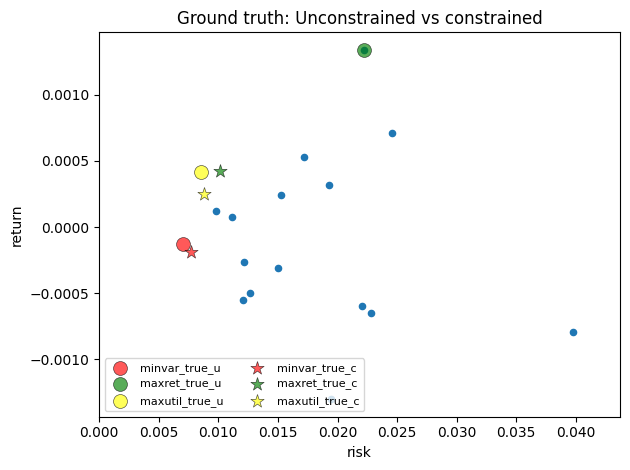

In [14]:
plot_scatter(title='Ground truth: Unconstrained vs constrained',
             true_u=optimal_portfolios_u,
             true_c=optimal_portfolios_c)

## Sample estimators of covmat and mean
The main question now is whether we are able to find the optimal allocation just from the
:code:`returns`. One obvious way to do it is to explicitly estimate mean and covariance matrix
and use the same optimizers as before to find the solution. If number of samples is big enough
this should work well!



In [15]:
markowitz_emp = Markowitz(returns.mean().values, returns.cov().values)

emp_portfolios_u = {'minvar': markowitz_emp.minvar(max_weight=1.),
                    'maxret': markowitz_emp.maxret(max_weight=1.),
                    'maxutil': markowitz_emp.maxutil(gamma=gamma, max_weight=1.)}

emp_portfolios_c = {'minvar': markowitz_emp.minvar(max_weight=max_weight),
                    'maxret': markowitz_emp.maxret(max_weight=max_weight),
                    'maxutil': markowitz_emp.maxutil(gamma=gamma, max_weight=max_weight)}

Let us see how the unconstrained portfolios compare with the ground truth.



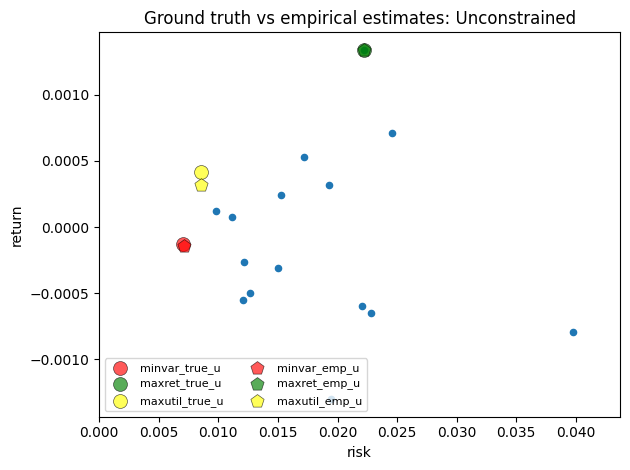

In [16]:
plot_scatter(title='Ground truth vs empirical estimates: Unconstrained',
             true_u=optimal_portfolios_u,
             emp_u=emp_portfolios_u)

Similarly, let's look at the constrained version.



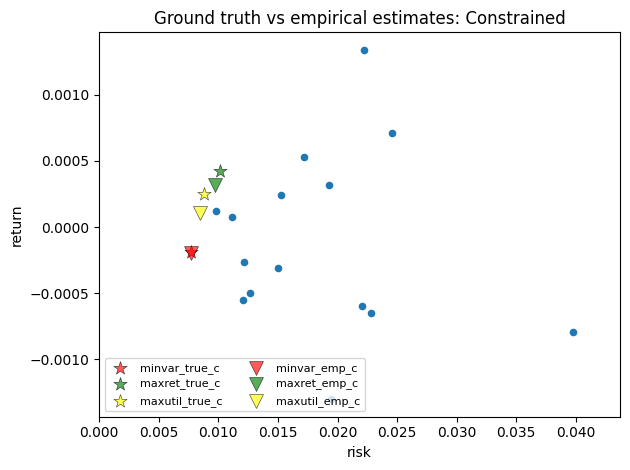

In [17]:
plot_scatter(title='Ground truth vs empirical estimates: Constrained',
             true_c=optimal_portfolios_c,
             emp_c=emp_portfolios_c)

We can see that under this setup, the empirical estimates are yielding close to optimal
portfolios.



## Implementation and setup of a :code:`deepdow` network
We would like to construct a network that accepts no input features, however, has
multiple learnable parameters that determine the result of a forward pass. Namely,
we are going to use the `layers_numericalmarkowitz` layer. Our goal is to learn
a mean return vector, covariance matrix and gamma totally from scratch. Note that
this is fundamentally different from using sample estimators as done in the previous section.



In [18]:
class Net(torch.nn.Module, Benchmark):
    """Learn covariance matrix, mean vector and gamma.

    One can enforce max weight per asset.
    """

    def __init__(self, n_assets, max_weight=1.):
        super().__init__()

        self.force_symmetric = True
        self.matrix = torch.nn.Parameter(torch.eye(n_assets), requires_grad=True)
        self.exp_returns = torch.nn.Parameter(torch.zeros(n_assets), requires_grad=True)
        self.gamma_sqrt = torch.nn.Parameter(torch.ones(1), requires_grad=True)

        self.portfolio_opt_layer = NumericalMarkowitz(n_assets, max_weight=max_weight)

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Tensor of shape `(n_samples, n_channels, lookback, n_assets)`.

        Returns
        -------
        weights_filled : torch.Tensor
            Of shape (n_samples, n_assets) representing the optimal weights as determined by the
            convex optimizer.

        """
        n = len(x)

        cov_sqrt = torch.mm(self.matrix, torch.t(self.matrix)) if self.force_symmetric else self.matrix

        weights = self.portfolio_opt_layer(self.exp_returns[None, ...],
                                           cov_sqrt[None, ...],
                                           self.gamma_sqrt,
                                           torch.zeros(1).to(device=x.device, dtype=x.dtype))
        weights_filled = torch.repeat_interleave(weights, n, dim=0)

        return weights_filled

Let us set some parameters. Note that :code:`lookback` is irrelevant since our network expects
no features. We need to define it anyway to be able to use :code:`deepdow` dataloaders.



In [19]:
lookback, gap, horizon = 2, 0, 5  # lookback does not matter in this case, just used for consistency
batch_size = 256
n_epochs = 100  # We employ early stopping

We are ready to create a :code:`DeepDow` dataset.



In [20]:
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(returns.values[i - lookback: i, :])
    y_list.append(returns.values[i + gap: i + gap + horizon, :])

X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]

dataset = InRAMDataset(X, y, asset_names=returns.columns)
dataloader = RigidDataLoader(dataset, batch_size=batch_size)

The main feature of :code:`deepdow` is that it only cares about the final allocation that minimizes
some function of **empirical** portfolio returns. Unlike with the sample estimators in the previous
sections, one does not need to explicitly model the dynamics of the market and find allocation via
the two step procedure. Below we define empirical counterparts of the convex optimization objectives
(losses). Note that all losses in :code:`deepdow` have the *the lower the better* logic.



In [21]:
all_losses = {'minvar': StandardDeviation() ** 2,
              'maxret': MeanReturns(),
              'maxutil': MeanReturns() + gamma * StandardDeviation() ** 2}

## Training and evaluation
Now it is time to train!



In [22]:
deep_portfolios_c = {}
deep_portfolios_u = {}

for mode in ['u', 'c']:
    for loss_name, loss in all_losses.items():
        network = Net(n_assets, max_weight=max_weight if mode == 'c' else 1.)
        run = Run(network,
                  loss,
                  dataloader,
                  val_dataloaders={'train': dataloader},
                  callbacks=[EarlyStoppingCallback('train', 'loss', patience=3)])

        run.launch(n_epochs=n_epochs)

        # Results
        w_pred = network(torch.ones(1, n_assets)).detach().numpy().squeeze()  # the input does not matter

        if mode == 'c':
            deep_portfolios_c[loss_name] = w_pred
        else:
            deep_portfolios_u[loss_name] = w_pred

Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 40.51it/s, loss=0.00005, train_loss=0.00005]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Epoch 7: 100%|██████████| 6/6 [00:00<00:00, 45.20it/s, loss=-0.00191, train_loss=-0.00187]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 39.48it/s, loss=0.00018, train_loss=0.00018]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 45.32it/s, loss=0.00006, train_loss=0.00006]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 45.69it/s, loss=-0.00032, train_loss=-0.00032]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 38.84it/s, loss=0.00056, train_loss=0.00056]


Training interrupted
Training stopped early because there was no improvement in train_loss for 3 epochs


Unconstrained case:



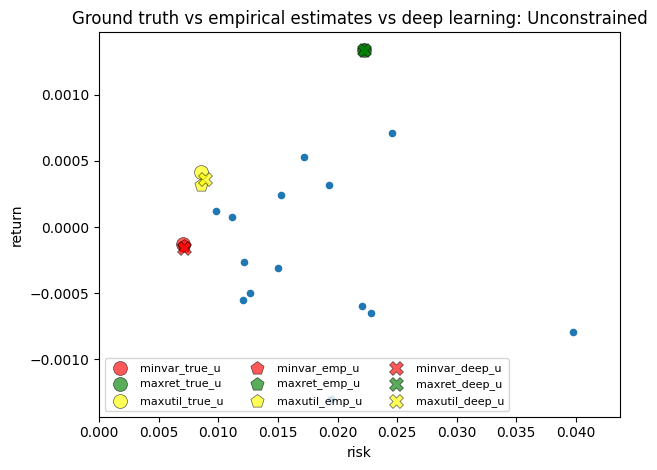

In [23]:
plot_scatter(title='Ground truth vs empirical estimates vs deep learning: Unconstrained',
             true_u=optimal_portfolios_u,
             emp_u=emp_portfolios_u,
             deep_u=deep_portfolios_u)

Constrained case:



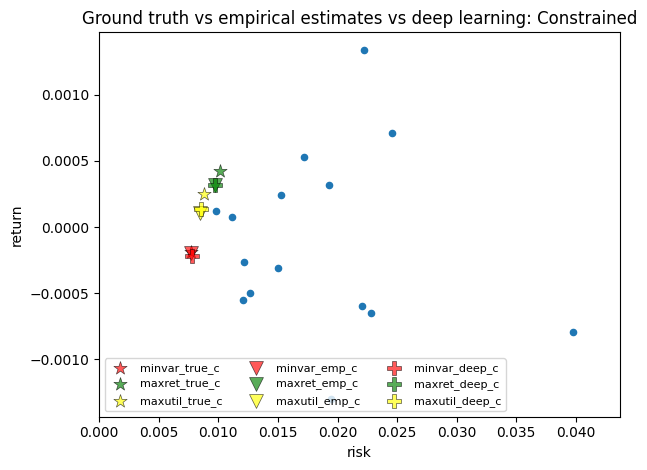

In [24]:
plot_scatter(title='Ground truth vs empirical estimates vs deep learning: Constrained',
             true_c=optimal_portfolios_c,
             emp_c=emp_portfolios_c,
             deep_c=deep_portfolios_c)